# Deep Learning Patent Classification

## Data ingestion

In [1]:
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros
import pandas as pd
import tensorflow as tf

from __future__ import print_function

from keras import initializers
from keras.models import Sequential
from keras.models import Model
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.layers import Input, InputLayer
from keras.layers import Embedding, Activation, Dropout, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization
from keras.layers.merge import Concatenate
# from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import one_hot
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import multi_gpu_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, binarize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from collections import defaultdict

import re
import os
from os import listdir
import seaborn as sns
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

import itertools
import operator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick


Using TensorFlow backend.
/home/alexmue/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


[nltk_data] Downloading package punkt to /home/alexmue/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alexmue/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
project_path = ''
#project_path = '/content/drive/My Drive/W266_Final_Project/'
path = project_path

all_files = [path + 'data/USPTO-2M/' + f for f in listdir(path + 'data/USPTO-2M') if f.endswith('.json')]

num_files_to_read = "all" # set to "all" or a number such as 2
if num_files_to_read == "all":
  print('Ingesting the following files:\n', sorted(all_files))
  patents = pd.concat(pd.read_json(f) for f in sorted(all_files))
else:
  print('Ingesting the following files:\n', sorted(all_files)[-num_files_to_read:])
  patents = pd.concat(pd.read_json(f) for f in sorted(all_files)[-num_files_to_read:])

Ingesting the following files:
 ['data/USPTO-2M/2006_USPTO.json', 'data/USPTO-2M/2007_USPTO.json', 'data/USPTO-2M/2008_USPTO.json', 'data/USPTO-2M/2009_USPTO.json', 'data/USPTO-2M/2010_USPTO.json', 'data/USPTO-2M/2011_USPTO.json', 'data/USPTO-2M/2012_USPTO.json', 'data/USPTO-2M/2013_USPTO.json', 'data/USPTO-2M/2014_USPTO.json', 'data/USPTO-2M/2015_USPTO.json']


## Exploratory Data Analysis

In [3]:
# Patents shape (all): (2000147, 4)

print(f"Patents shape: {patents.shape}")

Patents shape: (2000147, 4)


In [4]:
X = list(patents["Abstract"])

In [5]:
if num_files_to_read != "all":
  # Find number of unique_words
  abstract_words = [x for sent in X for x in sent.split(' ')]
  unique_words = len(set(abstract_words))
  print(f"Total number of words across all abstracts: {len(abstract_words):,}\nNumber of unique words across all abstracts: {unique_words:,}\n")

In [6]:
patents['tokens'] = patents['Abstract'].apply(nltk.word_tokenize)

In [0]:
#vectorizer = TfidfVectorizer(analyzer='word', max_df=0.3, min_df=25)
#vectorizer.fit_transform(list(patents['Abstract']))
#word_list = set([X for X in vectorizer.vocabulary_.keys()])
#L = list(patents.tokens)
#patents['tokens2'] = pd.Series([[X for X in Y if X in word_list] for Y in L])
#patents['Abstract2'] = pd.Series([" ".join(X) for X in patents['tokens2']])

In [7]:
patents.head()

,Abstract,No,Subclass_labels,Title,tokens
0,a magnetic disc unit having a rotating disc ty...,US07072141,[G11B],magnetic disc unit with range of gap between d...,"[a, magnetic, disc, unit, having, a, rotating,..."
1,methods and systems for transforming a volume ...,US06981282,[A41D],systems and methods for transformable suits,"[methods, and, systems, for, transforming, a, ..."
2,a gardening glove or the like designed to prev...,US06981283,[A41D],gardening gloves with cushion insert to protec...,"[a, gardening, glove, or, the, like, designed,..."
3,a hockey helmet for receiving a head of a wear...,US06981284,[A63B],hockey helmet comprising a lateral adjustment ...,"[a, hockey, helmet, for, receiving, a, head, o..."
4,a toilet and toilet system suitable for a boat...,US06981285,[E03D],toilet and method of operation,"[a, toilet, and, toilet, system, suitable, for..."


In [8]:
tokens = patents.tokens.tolist()
tokens = itertools.chain.from_iterable(tokens)
fdist1 = nltk.FreqDist(list(tokens))

In [9]:
# number of unique words
len(fdist1.most_common())

237230

In [10]:
# 25 least common words
fdist1.most_common()[-25:]

[('v2o5', 1),
 ('hfo1234ze', 1),
 ('casrgainssefwhere', 1),
 ('amfwherein', 1),
 ('srsialon', 1),
 ('prehydrolyzed', 1),
 ('nanogranule', 1),
 ('fosrenol', 1),
 ('meyenii', 1),
 ('xmno', 1),
 ('autodeposits', 1),
 ('tetraglycidyldiaminodiphenylmethane', 1),
 ('thixotrophy', 1),
 ('cheterocycloalkenyl', 1),
 ('metaloid', 1),
 ('pad3', 1),
 ('31g', 1),
 ('0517exp', 1),
 ('233exp', 1),
 ('porphyromonas', 1),
 ('prolipase', 1),
 ('rpsa', 1),
 ('ustilaginaceae', 1),
 ('basidomycetes', 1),
 ('benzylisoquinolines', 1)]

A subset of 1 year has roughly 32 million words, the whole dataset has roughly 200 million words.

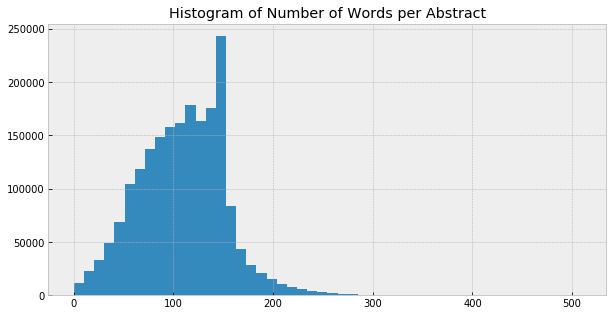

In [11]:
# Plot histogram of number of words in abstract
# plt.style.available
plt.style.use('bmh')
num_words_in_abstracts = [len(sent) for sent in patents['tokens']]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
axes.grid(b=None, axis="y")
pd.DataFrame(num_words_in_abstracts, columns=['Histogram of Number of Words per Abstract']).hist(bins=50, ax=axes)
pass

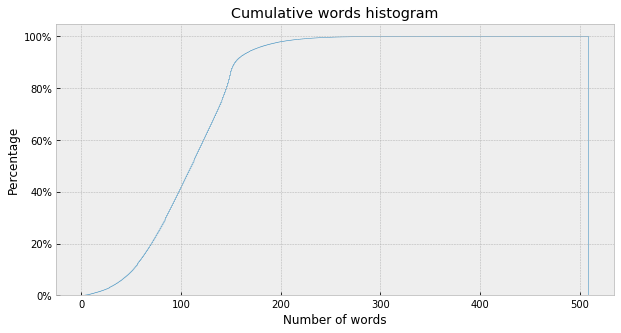

In [12]:
# Plot number of words in abstract as cumulative distribution

fig, ax = plt.subplots(figsize=(10, 5))

# plot the cumulative histogram
n, bins, patches = ax.hist(num_words_in_abstracts, 1000, density=True, histtype='step',
                           cumulative=True)

# tidy up the figure
ax.grid(True)
# ax.legend(loc='right')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_title('Cumulative words histogram')
ax.set_xlabel('Number of words')
ax.set_ylabel('Percentage')

plt.show()

In [13]:
pd.DataFrame(num_words_in_abstracts).describe()

,0
count,2.000147e+06
mean,1.090707e+02
std,4.308763e+01
min,0.000000e+00
25%,7.800000e+01
50%,1.110000e+02
75%,1.410000e+02
max,5.090000e+02


The abstracts have a mean length of rougly 100 words, the shortest has 1 word and the longest roughly 500 words.  Roughly 99% of patents have an abstract length of less than 200 words.

In [14]:
# Binarize labels into 1-hot encodings

CRC_labels = patents.Subclass_labels
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(CRC_labels)
num_CRC_labels = len(y[0])
print(f"Total number of CRC labels: {num_CRC_labels}")

Total number of CRC labels: 632


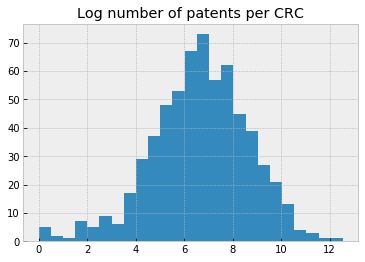

In [15]:
# Mini EDA on frequency of CRC labels

# Plot histogram of log number of patents per CRC label
fig, axes = plt.subplots(nrows=1, ncols=1)
num_patents_per_crc = np.sort(np.sum(y, axis=0))
pd.DataFrame(np.log(num_patents_per_crc), columns=['Log number of patents per CRC']).hist(bins=25, ax=axes)
pass


In [16]:
pd.DataFrame(num_patents_per_crc).describe()

,0
count,632.000000
mean,4239.625000
std,14699.945305
min,1.000000
25%,236.250000
50%,886.500000
75%,2940.500000
max,281876.000000


The most common crc class has 87740 patents. The mean crc class has 1272 patents (standard deviation 4538 patents).

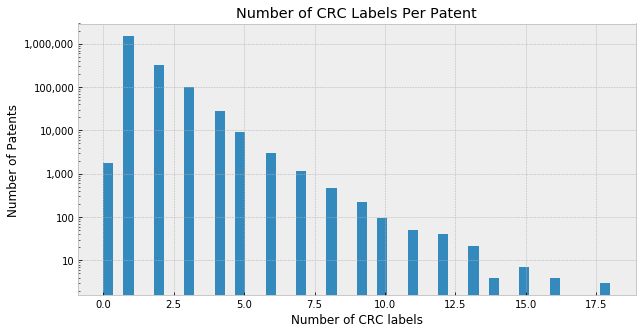

In [17]:
# Plot histogram of number of CRC labels per patent
plt.style.use('bmh')
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
num_crc_per_patent = np.sort(np.sum(y, axis=1))
pd.DataFrame(num_crc_per_patent, columns=['Number of CRC Labels Per Patent']).hist(bins=50, ax=axes)
axes.set_yscale('log')
axes.set_xlabel('Number of CRC labels')
axes.set_ylabel('Number of Patents')
axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
pass

In [18]:
pd.DataFrame(num_crc_per_patent).describe()

,0
count,2.000147e+06
mean,1.339623e+00
std,7.356278e-01
min,0.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,1.800000e+01


In [19]:
pd.DataFrame(num_crc_per_patent)[0].value_counts().sort_index(ascending=True)

0        1739
1     1525717
2      330643
3       99166
4       28580
5        9165
6        3052
7        1164
8         470
9         226
10         96
11         49
12         41
13         21
14          4
15          7
16          4
18          3
Name: 0, dtype: int64

In [20]:
print(f"Average number of labels per patent: {np.average(np.sum(y, axis=1))}")

Average number of labels per patent: 1.3396230377067286


- Each patent has on average 1.5 labels.
- Most patents (198 thousand) have just one label.
- There are 2 unlabeled examples.
- The maximum number of labels per patent are 16.
- Number of labels per patent decrease linearly on a log scale. (see histogram)

For 2M dataset, Top 10 CRC codes by count


* ('G02B', 37163)
* ('G01N', 42687)
* ('A61B', 48297)
* ('H04B', 52693)
* ('G06K', 55704)
* ('H04N', 66976)
* ('A61K', 77483)
* ('H04L', 77886)
* ('H01L', 132457)
* ('G06F', 281876)

In [21]:
# Top 10 CRC codes by count

from collections import Counter
CRC_codes = [(y) for x in patents["Subclass_labels"] for y in x]
result = dict(Counter(CRC_codes))
result_sorted = sorted(result.items(), key=lambda x: x[1])
list(result_sorted)[-10:]

[('G02B', 37163),
 ('G01N', 42687),
 ('A61B', 48297),
 ('H04B', 52693),
 ('G06K', 55704),
 ('H04N', 66976),
 ('A61K', 77483),
 ('H04L', 77886),
 ('H01L', 132457),
 ('G06F', 281876)]

Analysis of most common CRC codes:
- G06 = Computing (G06F = ELECTRIC DIGITAL DATA PROCESSING)
- H01 = Basic electric elements (H01L = SEMICONDUCTOR DEVICES)
- A61 = Medical or veterinary science; Hygiene (A61K = PREPARATIONS FOR MEDICAL, DENTAL, OR TOILET PURPOSES)
- H04 = electric communication technique (H04W = WIRELESS COMMUNICATION NETWORK)


## CPC subclass multilabel prediction - Experiment 3

In [22]:
X = list(patents["Abstract"])
abstract_words = [x for sent in X for x in sent.split(' ')]
unique_words = len(set(abstract_words))
CRC_labels = patents.Subclass_labels
# binarize labels into 1-hot encodings
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(CRC_labels)
num_CRC_labels = len(y[0])
print(f"Total number of CRC labels: {num_CRC_labels}")

Total number of CRC labels: 632


In [23]:
# Keep full patent table intact for analysis at end
P_train3, P_test3, y_train3, y_test3 = train_test_split(patents, y, test_size=0.20, random_state=42)
X_train3 = list(P_train3['Abstract'])
X_test3 = list(P_test3['Abstract'])

## Set training / test data based on Experiment Number

In [24]:
experiment_number = 3
if experiment_number == 1:
  (P_train, P_test, X_train, X_test, y_train, y_test) = (P_train1, P_test1, X_train1, X_test1, y_train1, y_test1)
elif experiment_number == 2:
  (P_train, P_test, X_train, X_test, y_train, y_test) = (P_train2, P_test2, X_train2, X_test2, y_train2, y_test2)
elif experiment_number == 3:
  (P_train, P_test, X_train, X_test, y_train, y_test) = (P_train3, P_test3, X_train3, X_test3, y_train3, y_test3)
elif experiment_number == 4:
  (P_train, P_test, X_train, X_test, y_train, y_test) = (P_train4, P_test4, X_train4, X_test4, y_train4, y_test4)
else:
  print(f"Unknown experiment number: {experiment_number}.")

## Embedding vectors

In [25]:
# Convert to word embeddings

# https://keras.io/preprocessing/text/
tokenizer = Tokenizer(num_words=unique_words)
tokenizer.fit_on_texts(X_train)

# Top 10 words
top10words = sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True)[:10]
# print("Top 10 words:\n", top10words)

# Convert text to sequence of numbers, each number representing a word
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# First 5 of X_train after texts_to_sequences conversion
# print("\nX_train:\n", X_train[0])

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# First of X_train after padding
# print("\nX_train (after padding):\n", X_train[:1])

In [26]:
# Use GloVe word embeddings to convert text inputs to their numeric counterparts

embeddings_dictionary = dict()

glove_file = open(path + "data/glove/glove.6B.100d.txt", encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# Print first item of embedding_matrix
# print(f"Embedding Matrix for {tokenizer.sequences_to_texts([[1]])}:\n{embedding_matrix[1:2]}")

## Custom metrics

In [27]:
# metric f1 definition
from keras import backend as K
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
def f1(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
def weighted_bce(y_true, y_pred):
    # weights become 2 if y_true is 1, and 1 if y_true is 0
    weights = (y_true * 2.) + (1. - y_true)
    bce = K.binary_crossentropy(y_true, y_pred)
    weighted_bce = K.mean(bce * weights)
    return weighted_bce

## CNN 

In [28]:
filters = 512
hidden_dims = 512
print('Build model...')
input = tf.keras.Input(shape=(maxlen,), name='input_embeddings')
embedding = tf.python.keras.layers.Embedding(vocab_size, 100,
                    input_length=maxlen, weights=[embedding_matrix],
                                             trainable=False)(input)
conv0 = tf.keras.layers.Conv1D(filters, 2, activation='relu')(embedding)
maxpool0 = tf.keras.layers.GlobalMaxPooling1D()(conv0)
conv1 = tf.keras.layers.Conv1D(filters, 3, activation='relu')(embedding)
maxpool1 = tf.keras.layers.GlobalMaxPooling1D()(conv1)
conv2 = tf.keras.layers.Conv1D(filters, 4, activation='relu')(embedding)
maxpool2 = tf.keras.layers.GlobalMaxPooling1D()(conv2)
conv3 = tf.keras.layers.Conv1D(filters, 5, activation='relu')(embedding)
maxpool3 = tf.keras.layers.GlobalMaxPooling1D()(conv3)
concat1 = tf.keras.layers.concatenate([maxpool0, maxpool1, maxpool2, maxpool3], axis=1)
dropout1 = tf.keras.layers.Dropout(rate=0.2)(concat1)
dense = tf.keras.layers.Dense(hidden_dims, activation='relu', name='dense')(dropout1)
batchnorm = tf.keras.layers.BatchNormalization()(dense)
dense = tf.keras.layers.Dropout(rate=0.5)(batchnorm)
pred = tf.keras.layers.Dense(num_CRC_labels, activation='sigmoid', name='crc')(dense)
model = tf.keras.models.Model(inputs=input, outputs=pred)

Build model...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_embeddings (InputLayer)   [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 100)     21382700    input_embeddings[0][0]           
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 199, 512)     102912      embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 198, 512)     154112      embedding[0][0]                  
______________________________________________________________________________________________

### CNN model on CPC subclass level

In [30]:
model.compile(loss=weighted_bce,
              optimizer='adam',
              metrics=[f1,
                      tf.keras.metrics.Precision(name='precision'),
                      tf.keras.metrics.Precision(name='precision_1', top_k=1),
                      tf.keras.metrics.Recall(name='recall'),
                      tf.keras.metrics.Recall(name='recall_5', top_k=5)])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [31]:
history3 = model.fit(X_train, y_train,
          batch_size=128,
          epochs=5,
          validation_data=(X_test, y_test))

Train on 1600117 samples, validate on 400030 samples
Epoch 1/5
1600117/1600117 [==============================] - 397s 248us/sample - loss: 0.0152 - f1: 0.4242 - precision: 0.2571 - precision_1: 0.4990 - recall: 0.3523 - recall_5: 0.6805 - val_loss: 0.0092 - val_f1: 0.5143 - val_precision: 0.6360 - val_precision_1: 0.5889 - val_recall: 0.4319 - val_recall_5: 0.7751
Epoch 2/5
1600117/1600117 [==============================] - 377s 235us/sample - loss: 0.0098 - f1: 0.5006 - precision: 0.5944 - precision_1: 0.5760 - recall: 0.4328 - recall_5: 0.7564 - val_loss: 0.0086 - val_f1: 0.5400 - val_precision: 0.6511 - val_precision_1: 0.6169 - val_recall: 0.4613 - val_recall_5: 0.7967
Epoch 3/5
1600117/1600117 [==============================] - 376s 235us/sample - loss: 0.0094 - f1: 0.5179 - precision: 0.6048 - precision_1: 0.5940 - recall: 0.4532 - recall_5: 0.7721 - val_loss: 0.0084 - val_f1: 0.5536 - val_precision: 0.6427 - val_precision_1: 0.6253 - val_recall: 0.4862 - val_recall_5: 0.8059
Ep

### CNN model evaluation

In [32]:
score = model.evaluate(X_test, y_test, verbose=1)
score

400030/400030 [==============================] - 49s 122us/sample - loss: 0.0081 - f1: 0.5644 - precision: 0.6469 - precision_1: 0.6370 - recall: 0.5004 - recall_5: 0.8147


[0.008138911377847086, 0.564383, 0.6469483, 0.6369822, 0.5003639, 0.81471944]

In [33]:
def plot_metric(hist, metrics, title):
  for metric in metrics:
    metric_to_plot = hist[metric]
    plt.plot(metric_to_plot, label=metric)
  plt.title(title)
  plt.legend()
  plt.xlabel("epoch")
  plt.ylabel("metric")


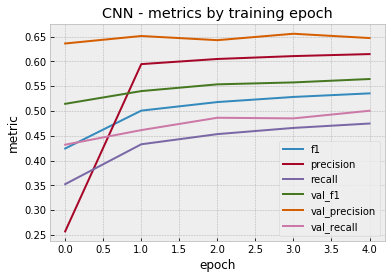

In [34]:
plot_metric(history3.history, ["f1", "precision", "recall", "val_f1", "val_precision", "val_recall"], "CNN - metrics by training epoch")

# Analysis of Results

In [35]:
def convert_to_0_1_1D(a):
  """Return row - for each val in row: 1 if val > 0.5, else 0"""
  return np.round(a).astype(int)
  # return binarize(a.reshape(1,-1), threshold=0.4).astype(int)

def convert_to_0_1_2D(y):
  return np.apply_along_axis(convert_to_0_1_1D, 0, y)

def partial_or_exact_match(y1, y2):
  return sum(y1 & y2)

In [36]:
y_pred = model.predict(X_test)
y_pred_0_1 = convert_to_0_1_2D(y_pred)

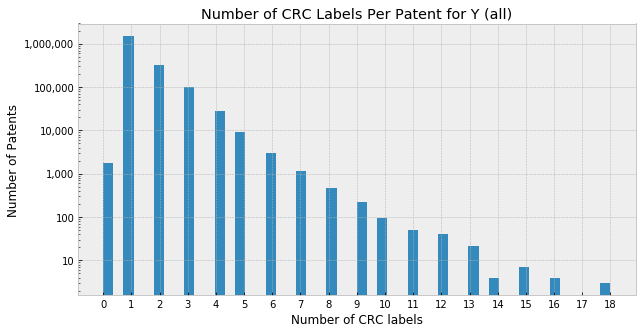

In [37]:
# Plot histogram of number of CRC labels per patent for y
plt.style.use('bmh')
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
num_crc_per_patent = np.sort(np.sum(y, axis=1))
pd.DataFrame(num_crc_per_patent, columns=['Number of CRC Labels Per Patent for Y (all)']).hist(bins=50, ax=axes)
axes.set_yscale('log')
axes.set_xlabel('Number of CRC labels')
axes.set_ylabel('Number of Patents')
axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
axes.xaxis.set_major_locator(ticker.MultipleLocator(1))
pass

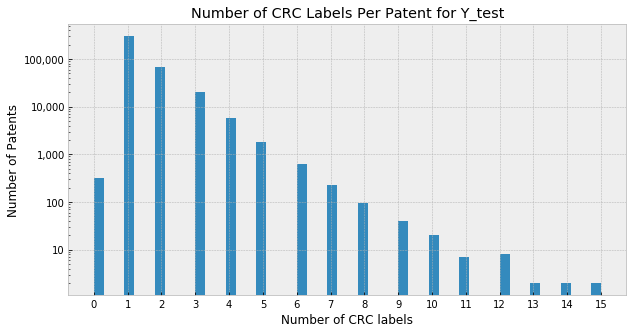

In [38]:
# Plot histogram of number of CRC labels per patent for y_test
plt.style.use('bmh')
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
num_crc_per_patent = np.sort(np.sum(y_test, axis=1))
pd.DataFrame(num_crc_per_patent, columns=['Number of CRC Labels Per Patent for Y_test']).hist(bins=50, ax=axes)
axes.set_yscale('log')
axes.set_xlabel('Number of CRC labels')
axes.set_ylabel('Number of Patents')
axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
axes.xaxis.set_major_locator(ticker.MultipleLocator(1))
pass

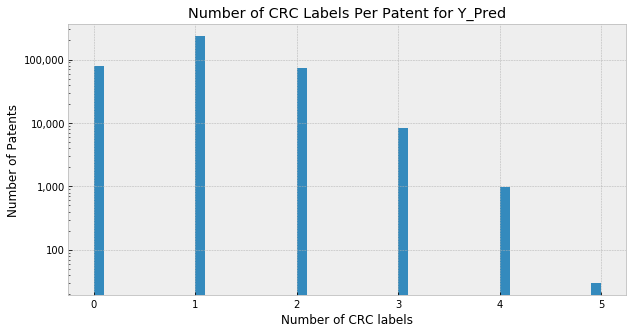

In [39]:
# Plot histogram of number of CRC labels per patent for y_pred
plt.style.use('bmh')
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
num_crc_per_patent = np.sort(np.sum(convert_to_0_1_2D(y_pred), axis=1))
pd.DataFrame(num_crc_per_patent, columns=['Number of CRC Labels Per Patent for Y_Pred']).hist(bins=50, ax=axes)
axes.set_yscale('log')
axes.set_xlabel('Number of CRC labels')
axes.set_ylabel('Number of Patents')
axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
axes.xaxis.set_major_locator(ticker.MultipleLocator(1))

pass

In [40]:
# Determine exact and partial matches
exact_matches = []
partial_matches = []

for i in range(len(y_pred)):
  y1 = y_test[i]
  y2 = convert_to_0_1_1D(y_pred[i])
  if np.array_equal(y1, y2):
    exact_matches.append(i)
  elif partial_or_exact_match(y1, y2):
     # only partial matches because exact matches get filtered out in the code above
    partial_matches.append(i)

In [41]:
print(f"Number of exact matches between y_pred & y_test: {len(exact_matches)}")
print(f"Number of partial matches between y_pred & y_test: {len(partial_matches)}")
print(f"Total number of possible matches between y_pred & y_test: {len(y_pred)}")

Number of exact matches between y_pred & y_test: 154054
Number of partial matches between y_pred & y_test: 95137
Total number of possible matches between y_pred & y_test: 400030


In [42]:
print(f"Ave number of labels per patent for y_test: {round(sum(sum(y_test))/len(y_test),2)}")
print(f"Ave number of labels per patent for y_pred: {round(sum(sum(y_pred_0_1))/len(y_pred_0_1),2)}")

# Find number of predictions in which no labels were predicted
print(f"Number of patents in which no labels were predicted: {len(y_pred_0_1) - np.count_nonzero(np.sum(y_pred_0_1, axis=1)):,} out of {len(y_pred_0_1):,}")

Ave number of labels per patent for y_test: 1.34
Ave number of labels per patent for y_pred: 1.04
Number of patents in which no labels were predicted: 79,982 out of 400,030


In [43]:
P_test_no_predicted_labels = P_test[np.where(np.sum(y_pred_0_1, axis=1) == 0, True, False)]
P_test_no_predicted_labels.head()


,Abstract,No,Subclass_labels,Title,tokens
114940,a security case includes a shell formed of a w...,US07528733,[G08B],security case and method of manufacture,"[a, security, case, includes, a, shell, formed..."
2962,cd storage device is disclosed which includes ...,US07505259,"[H05K, G11B]",cd rom storage device,"[cd, storage, device, is, disclosed, which, in..."
139416,an ice cream maker including a blade arranged ...,US07878021,[A23G],simplified ice cream maker,"[an, ice, cream, maker, including, a, blade, a..."
219158,a method for producing a suspension emulsion o...,US08709460,[A01N],chemical method of making a suspension emulsio...,"[a, method, for, producing, a, suspension, emu..."
17927,a household appliance configured to communicat...,US08942835,"[H02J, G06F, D06F, H04L]",system and method of operating household appli...,"[a, household, appliance, configured, to, comm..."


In [44]:
# P_test.loc[[45918]] # loc is row with the specified index value

In [45]:
# idx_val = np.where(P_test.index.values == 148568)[0][0]
# P_test.iloc[[idx_val]] # iloc is actual row # specified

In [46]:
kstone_testing = 0
if kstone_testing == 1:
  CRC_list = mlb.classes_
  for idx_num in [45918, 148568, 46527, 291845, 250456]:
    i = np.where(P_test.index.values == idx_num)[0][0]
    print(f"For Patent #{i} with labels {list(P_test.iloc[[i]]['Subclass_labels'])}:\n")
    for threshold in [0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.01]:
      extra_num = sum(sum(binarize(y_pred[i].reshape(1,-1), threshold=threshold).astype(int) != np.round(y_pred[i]).astype(int)))
      print(f"Threshold: {threshold}, Additional number of labels: {extra_num}, labels: {CRC_list[binarize(y_pred[i].reshape(1,-1), threshold=threshold).astype(int).astype(bool)[0]]}")
    print("")

In [47]:
def matched_labels(df):
  labels = []
  for val in df:
    for val2 in val:
      labels.append(val2)
  return labels, set(labels)

# Number of unique CRC labels that were matched exactly
t1, t1s = matched_labels(P_test.iloc[exact_matches,:]['Subclass_labels'])
print(f"Number of CRC labels that were part of an exact match: {len(t1s)}")

# Number of unique CRC labels that were partially matched
t2, t2s = matched_labels(P_test.iloc[partial_matches,:]['Subclass_labels'])
print(f"Number of CRC labels that were part of a partial match: {len(t2s)}")

# Number of unique CRC labels that were exactly and/or partially matched exactly
t1s_t2s = set(list(t1s) + list(t2s))
print(f"Number of CRC labels that were part of an exact and/or partial match: {len(t1s_t2s)}")

# Total number of unique CRC labels in test set
t3, t3s = matched_labels(P_test['Subclass_labels'])
print(f"Total Number of CRC labels in test set: {len(t3s)}")


Number of CRC labels that were part of an exact match: 391
Number of CRC labels that were part of a partial match: 596
Number of CRC labels that were part of an exact and/or partial match: 597
Total Number of CRC labels in test set: 622


In [48]:
# save list of CRC labels that aligns to one-hot encoding
CRC_list = mlb.classes_

def calc_PR(CRC_list, letter, y_true, y_pred):
  '''
  Returns mask of dimension # test examples by # of labels
  '''
  m = []
  for CRC in CRC_list:
    if CRC[0] == letter:
      m.append(1)
    else:
      m.append(0)
  mask = np.repeat([m], y_true.shape[0], axis=0)
  recall    = sum(sum(mask * y_test * y_pred)) / sum(sum(mask * y_test))
  precision = sum(sum(mask * y_test * y_pred)) / sum(sum(mask * y_pred))
  f1 = 2*recall*precision/(recall + precision)

  num_abstracts = sum([1 for X in np.sum(mask * y_test, axis=1) if X > 0])

  print(f"{letter}> Recall: {round(recall, 2):0.2f}, Precision: {round(precision, 2):0.2f}, F1: {round(f1, 2):0.2f}, Num: {num_abstracts}")

y_pred_0_1 = convert_to_0_1_2D(y_pred)
for letter in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
  calc_PR(CRC_list, letter, y_test, y_pred_0_1)


A> Recall: 0.59, Precision: 0.71, F1: 0.65, Num: 58400
B> Recall: 0.31, Precision: 0.61, F1: 0.41, Num: 57740
C> Recall: 0.43, Precision: 0.58, F1: 0.50, Num: 41138
D> Recall: 0.25, Precision: 0.64, F1: 0.36, Num: 2438
E> Recall: 0.32, Precision: 0.69, F1: 0.43, Num: 9519
F> Recall: 0.38, Precision: 0.58, F1: 0.46, Num: 27173
G> Recall: 0.56, Precision: 0.69, F1: 0.62, Num: 142986
H> Recall: 0.55, Precision: 0.62, F1: 0.58, Num: 119198


In [49]:
# Find % of exact matches by CRC (does not include partial matches)

f1 = nltk.FreqDist(t1)
f1mc = f1.most_common()

f2 = nltk.FreqDist(t3)
f2mc = f2.most_common()

list1 = []
for label1, num1 in f1mc:
  for label2, num2 in f2mc:
    if label1 == label2:
      # print(f"{label1}: # in exact match-{num1}, Total-{num2}, {round(100*num1/num2,2)}%")
      list1.append([label1, num1, num2, round(num1/num2,2)])
      break

list1.sort(key=lambda x:x[3], reverse=True)
list1[:10]

[['A01H', 2819, 3564, 0.79],
 ['H01L', 18288, 26344, 0.69],
 ['G03G', 2915, 4261, 0.68],
 ['A63B', 1682, 2476, 0.68],
 ['G10D', 200, 300, 0.67],
 ['G11B', 3624, 5474, 0.66],
 ['H01R', 2874, 4612, 0.62],
 ['H01M', 2185, 3515, 0.62],
 ['B41J', 2623, 4411, 0.59],
 ['G06F', 31382, 56452, 0.56]]

In [50]:
# convert preditions to CRC labels
t0 = convert_to_0_1_2D(y_pred).astype(bool)
l1 = []
for i in range(P_test.shape[0]):
  if sum(t0[i]) > 0:
    l1.append(list(CRC_list[t0[i]]))
  else:
    l1.append([""])

In [51]:
# Add predicted CRC labels to P_test dataframe
l2 = pd.Series(l1)
P_test.reset_index(inplace=True)
P_test['Predicted_labels'] = l2
P_test.set_index('index', inplace=True, drop=True)

/home/alexmue/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [52]:
def analyze_CRC_prediction(df, y_test, y_pred, label):
  '''
  Returns...
    rows from df in which label was predicted correctly
    rows from df in which label was predicted incorrectly
    Percent correctly predicted for label
  '''
  label_loc = list(CRC_list).index(label)
  correct_rows_all = y_test * convert_to_0_1_2D(y_pred)
  incorrect_rows_all = y_test * np.logical_not(convert_to_0_1_2D(y_pred))
  pct_correct = sum(correct_rows_all[:,label_loc]) / sum(y_test[:,label_loc])
  correct_rows_df = df[correct_rows_all[:,label_loc].astype(bool)] # labelled correctly
  incorrect_rows_df = df[incorrect_rows_all[:,label_loc].astype(bool)] # not labelled correctly

  return correct_rows_df, incorrect_rows_df, pct_correct

correct_rows_A01H, incorrect_rows_A01H, pct_correct_A01H = analyze_CRC_prediction(P_test, y_test, y_pred, 'A01H')

https://www.uspto.gov/web/patents/classification/cpc/html/cpc-A01H.html

NEW PLANTS OR PROCESSES FOR OBTAINING THEM; PLANT REPRODUCTION BY TISSUE CULTURE TECHNIQUES

This subclass covers all aspects related to new plants, including disease resistance, cold resistance and growth speed. In this subclass, angiosperms, i.e. flowering plants, are classified in group A01H 6/00 according to their botanic taxonomy and in group A01H 5/00 according to their plant parts, where disclosed.

https://www.uspto.gov/web/patents/classification/cpc/html/cpc-C12N.html

MICROORGANISMS OR ENZYMES; COMPOSITIONS THEREOF (biocides, pest repellants or attractants, or plant growth regulators, containing microorganisms, viruses, microbial fungi, enzymes, fermentates or substances produced by or extracted from microorganisms or animal material A01N 63/00; food compositions A21, A23; medicinal preparations A61K; chemical aspects of, or use of materials for, bandages, dressings, absorbent pads or surgical articles A61L; fertilisers C05); PROPAGATING, PRESERVING OR MAINTAINING MICROORGANISMS (preservation of living parts of humans or animals A01N 1/02); MUTATION OR GENETIC ENGINEERING; CULTURE MEDIA (microbiological testing media C12Q)

In [53]:
correct_rows_A01H.head()
correct_rows_A01H.head().loc[:,['Subclass_labels', 'Predicted_labels']]

,Subclass_labels,Predicted_labels
index,,
134376,[A01H],[A01H]
62620,[A01H],[A01H]
137253,[A01H],"[A01H, C12N]"
174390,"[C12N, A01H]","[A01H, C12N]"
220302,"[C12N, A01H]","[A01H, C12N]"


In [54]:
incorrect_rows_A01H.head()
incorrect_rows_A01H.head().loc[:,['Subclass_labels', 'Predicted_labels']]

,Subclass_labels,Predicted_labels
index,,
129384,"[C12P, C07K, A01H]","[C07K, C12N]"
118429,"[A01H, C12N]","[C07H, C12N, C12P]"
10250,"[C07H, A01H, C12N]",[C12N]
272322,"[A01H, C12N]",[C12N]
406,"[A01H, C12N]",[C12N]


In [55]:
import pprint

# Example abstract when A01H correctly predicted

print("Example abstract when A01H correctly predicted...")
pp = pprint.PrettyPrinter(indent=1, width=80)
pp.pprint(list(correct_rows_A01H.head(1)['Abstract']))
print("")

# Example abstract when A01H incorrectly predicted

print("Example abstract when A01H was not predicted even though it should have been...")
pp.pprint(list(incorrect_rows_A01H.head(1)['Abstract']))

Example abstract when A01H correctly predicted...
['a new and distinct hybrid of artichoke named ps h1860 characterized by its '
 'numerous bud numbers fleshiness of bracts fleshiness of hearts and '
 'uniformity of head shapes ability to bolt in warm summer conditions reduced '
 'vernalization requirements allowing spring summer planting and fall '
 'production']

Example abstract when A01H was not predicted even though it should have been...
['the present invention relates to the fields of molecular biology and plant '
 'biology specifically the invention is directed to the methods for expressing '
 'spider silk proteins in plants and the synthesis and purification of spider '
 'silk proteins therefrom']


In [56]:
def analyze_label_pairings(y):
  '''
  Returns array of counts for each label and their pairs
  '''
  pairs = []
  for i in range(len(CRC_list)):
    # Return rows where column corresponding to label has a 1
    label_rows = y[y[:,i].astype(bool)]
    pairs.append(list(np.sum(label_rows, axis=0)))

  return np.array(pairs)

In [57]:
y_pred_0_1 = convert_to_0_1_2D(y_pred)

# Find labels that are most commonly paired with A01H in y_test
print(f"From y-test for A01H...")
pairs_ytest = analyze_label_pairings(y_test)
pairs_A01H = pairs_ytest[list(CRC_list).index('A01H')]
print(f"Labels: {CRC_list[pairs_A01H.argsort()[-10:]]}")
print(f"Counts: {pairs_A01H[pairs_A01H.argsort()[-10:]]}")
print("")

# Find labels that are most commonly paired with A01H in y_pred
print(f"From y-pred for A01H predicted and other labels predicted...")
pairs_ypred = analyze_label_pairings(y_pred_0_1)
pairs_A01H = pairs_ypred[list(CRC_list).index('A01H')]
print(f"Labels: {CRC_list[pairs_A01H.argsort()[-10:]]}")
print(f"Counts: {pairs_A01H[pairs_A01H.argsort()[-10:]]}")
print("")

print(f"From y-pred for A01H (A01H predicted correctly and other labels predicted)...")
# Create A01H correct mask
A01H_loc = list(CRC_list).index('A01H')
mask = np.ones(shape=y_test.shape, dtype=np.int8)
mask[:,A01H_loc] = y_test[:,list(CRC_list).index('A01H')]
pairs_ypred = analyze_label_pairings(mask * y_pred_0_1)
pairs_A01H = pairs_ypred[list(CRC_list).index('A01H')]
print(f"Labels: {CRC_list[pairs_A01H.argsort()[-10:]]}")
print(f"Counts: {pairs_A01H[pairs_A01H.argsort()[-10:]]}")
print("")

print(f"From y-pred for A01H (A01H predicted incorrectly and other labels predicted)...")
A01H_loc = list(CRC_list).index('A01H')
mask = np.ones(shape=y_test.shape, dtype=np.int8)
mask[:,A01H_loc] = y_test[:,list(CRC_list).index('A01H')]
y_pred_0_1x = convert_to_0_1_2D(y_pred)
y_pred_0_1x[:,A01H_loc] = np.logical_not(y_pred_0_1)[:,A01H_loc]
pairs_ypred = analyze_label_pairings(mask * y_pred_0_1x)
pairs_A01H = pairs_ypred[list(CRC_list).index('A01H')]
print(f"Labels: {CRC_list[pairs_A01H.argsort()[-10:]]}")
print(f"Counts: {pairs_A01H[pairs_A01H.argsort()[-10:]]}")
print("")

# Find labels that are most commonly paired with A01H in y_pred_correct
print(f"From y-pred for A01H (A01H predicted correctly and other labels that were also predicted correctly)...")
# pairs_ypred_correct = analyze_label_pairings(y_test * y_pred_0_1)
# pairs_A01H_correct = pairs_ypred_correct[list(CRC_list).index('A01H')]
# print(f"Labels: {CRC_list[pairs_A01H_correct.argsort()[-10:]]}")
# print(f"Counts: {pairs_A01H_correct[pairs_A01H_correct.argsort()[-10:]]}")
# print("")

# Find labels that are most commonly paired with A01H in y_pred_incorrect
print(f"From y-pred for A01H (A01H predicted incorrectly and other labels predicted incorrectly)...")
# pairs_ypred_incorrect = analyze_label_pairings(y_test * np.logical_not(y_pred_0_1))  
# pairs_A01H_incorrect = pairs_ypred_incorrect[list(CRC_list).index('A01H')]
# print(f"Labels: {CRC_list[pairs_A01H_incorrect.argsort()[-10:]]}")
# print(f"Counts: {pairs_A01H_incorrect[pairs_A01H_incorrect.argsort()[-10:]]}")
# print("")

print(f"From y-pred for A01H (A01H predicted incorrectly and other labels predicted correctly)...")
print("")


From y-test for A01H...
Labels: ['A23K' 'A01G' 'A01N' 'C12Q' 'C12P' 'A23L' 'C07K' 'C07H' 'C12N' 'A01H']
Counts: [  10   15   21   29   41   50  154  220 1573 3564]

From y-pred for A01H predicted and other labels predicted...
Labels: ['G01N' 'A01G' 'C12Q' 'A01N' 'C07K' 'A61K' 'C12P' 'C07H' 'C12N' 'A01H']
Counts: [   2    3    3    6    6    8   64  259 1888 3678]

From y-pred for A01H (A01H predicted correctly and other labels predicted)...
Labels: ['B32B' 'G01N' 'C12Q' 'C07K' 'A01N' 'A61K' 'C12P' 'C07H' 'C12N' 'A01H']
Counts: [   0    1    2    2    2    6   32  177 1662 3433]

From y-pred for A01H (A01H predicted incorrectly and other labels predicted)...
Labels: ['A01G' 'A01C' 'A01N' 'C12Q' 'A61K' 'C07K' 'C12P' 'C07H' 'C12N' 'A01H']
Counts: [  2   3   6   7  12  18  25  31  80 131]

From y-pred for A01H (A01H predicted correctly and other labels that were also predicted correctly)...
From y-pred for A01H (A01H predicted incorrectly and other labels predicted incorrectly)...
From y-p

For A01H, 610 correct labels in y_test. System predicted 558 of 610 correctly.  System predicted 24 A01H's (582-558) when no A01H label should have been predicted.

## TF-IDF Analysis


In [106]:
# tfidfconverter = TfidfVectorizer(max_df=0.5)
# X = tfidfconverter.fit_transform(list(patents['Abstract']))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Binarize labels into 1-hot encodings

# CRC_labels = patents.Subclass_labels
# mlb = MultiLabelBinarizer()
# y = mlb.fit_transform(CRC_labels)
# num_CRC_labels = len(y[0])
# print(f"Total number of CRC labels: {num_CRC_labels}")

Total number of CRC labels: 624


In [0]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [0]:
# classifier = RandomForestClassifier(n_estimators=100, random_state=0)
# classifier.fit(X, y) 

In [16]:
# y_pred = classifier.predict(X)

# print(confusion_matrix(y_test,y_pred))
# print(classification_report(y_test,y_pred))
# print(accuracy_score(y_test, y_pred))

NameError: ignored

## Scratch Work

In [74]:
# patents.head()

,Subclass_labels,Abstract,Title,No,tokens
0,"[A61B, G09B]",a method is presented to address quantitative ...,method and system for quantitative assessment ...,US08777630,"[a, method, is, presented, to, address, quanti..."
1,[E21B],in a method for drilling a borehole real time ...,method for drilling a borehole,US08857538,"[in, a, method, for, drilling, a, borehole, re..."
2,"[C23C, H01J]",a magnetron actuator for moving a magnetron in...,homing device for magnetron rotating on two arms,US08900427,"[a, magnetron, actuator, for, moving, a, magne..."
3,"[H05K, C23C, G06F]",a method of making a touch sensor assembly com...,touch sensor assembly and method of making the...,US08822833,"[a, method, of, making, a, touch, sensor, asse..."
4,"[C07D, A61K, A61P]",provided herein are novel epoxide inhibitors o...,epoxide inhibitors of cysteine proteases,US08673904,"[provided, herein, are, novel, epoxide, inhibi..."


In [0]:
kstone_testing = 0

if kstone_testing == 1:
  def matching_label_df(patents_df, label):
    '''
    Return dataframe of patents that contain label
    '''
    matching_list = [label in X for X in patents_df['Subclass_labels']]
    return patents_df[matching_list]

  # https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting

  def create_idf_dict(df):
    vectorizer1 = TfidfVectorizer()
    X = vectorizer1.fit_transform(list(df['Abstract']))
    list_all = vectorizer1.get_feature_names()
    # and idf calculated as ln((N+1)/(df + 1)) + 1 = ln(5/2) + 1 = 1.91629
    idf_dict = {}
    for word, idf_val in zip(list_all,vectorizer1.idf_):
      idf_dict[word] = idf_val
    return idf_dict

In [0]:
if kstone_testing == 1:
  AO1H_all_df = matching_label_df(P_test, 'A01H')
  AO1H_exm_df = matching_label_df(P_test.iloc[exact_matches,:], 'A01H')
  H04J_all_df = matching_label_df(P_test, 'H04J')
  H04J_exm_df = matching_label_df(P_test.iloc[exact_matches,:], 'H04J')

  idf_all_dict = create_idf_dict(P_test)
  idf_A01H_all_dict = create_idf_dict(AO1H_all_df)
  idf_A01H_exm_dict = create_idf_dict(AO1H_exm_df)
  idf_H04J_all_dict = create_idf_dict(H04J_all_df)
  idf_H04J_exm_dict = create_idf_dict(H04J_exm_df)

  # Calc IDF_all / IDF_CRC for all words
  def calc_idf_ratio(dict1, dict2, num_print=0):
    idf_ratio_dict = defaultdict(lambda: 0)
    for word in dict2.keys():
      idf_ratio_dict[word] = dict1[word] / dict2[word]

    if num_print > 0:
      sorted_x = sorted(idf_ratio_dict.items(), key=operator.itemgetter(1), reverse=True)
      print(*sorted_x[:num_print], sep="\n")
      print()
    return idf_ratio_dict

  idf_ratio_dict = calc_idf_ratio(idf_all_dict, idf_A01H_all_dict, 25)
  idf_ratio_dict = calc_idf_ratio(idf_all_dict, idf_A01H_exm_dict, 25)
  idf_ratio_dict = calc_idf_ratio(idf_all_dict, idf_H04J_all_dict, 25)
  idf_ratio_dict = calc_idf_ratio(idf_all_dict, idf_H04J_exm_dict, 25)

('plant', 4.372128949985305)
('plants', 3.7924992696086965)
('crossing', 3.1856240653329992)
('variety', 3.1286420506245083)
('seeds', 3.1069615135442166)
('cultivar', 3.073370756706303)
('habit', 2.9950693642470028)
('designated', 2.9804085948177614)
('named', 2.9476517681999703)
('distinct', 2.907867843665081)
('flowers', 2.892459118565836)
('genetic', 2.8630645547098696)
('seed', 2.8201006508901454)
('produced', 2.737143625854371)
('varieties', 2.6816360121247946)
('soybean', 2.6603144972330783)
('cultures', 2.650234973709479)
('new', 2.6239989349325383)
('hybrid', 2.553076161499554)
('vigorous', 2.5424991921405984)
('breeding', 2.5414511079319184)
('flowering', 2.535907118539357)
('transgenic', 2.5327096202112087)
('producing', 2.508695894236098)
('purple', 2.486894892849658)

('plant', 4.663391035636017)
('cultivar', 3.6455029339241998)
('habit', 3.618870392308261)
('named', 3.542394440653551)
('distinct', 3.5129178731217245)
('flowers', 3.486380191803211)
('plants', 3.41834024977

In [58]:
def patent_stats(patents_df):
  '''
  Return # of unique words in abstracts, FreqDist of words in abstracts
  '''
  X = list(patents_df["Abstract"])

  # Find number of unique_words
  abstract_words = [x for sent in X for x in sent.split(' ')]
  unique_words = len(set(abstract_words))

  tokens = patents_df.tokens.tolist()
  tokens = itertools.chain.from_iterable(tokens)
  stopwords = nltk.corpus.stopwords.words('english')
  filtered_tokenized_text = [word for word in tokens if word not in stopwords]
  fdist1 = nltk.FreqDist(filtered_tokenized_text)

  return (fdist1, unique_words)

# fdist1, unique_words1 = patent_stats(new_df)
# fdist2, unique_words2 = patent_stats(patents)

In [59]:
# Top 10 CRC codes by count

from collections import Counter
CRC_codes = [(y) for x in patents["Subclass_labels"] for y in x]
result = dict(Counter(CRC_codes))
result_sorted = sorted(result.items(), key=lambda x: x[1])
list(result_sorted)[-10:]

[('G02B', 37163),
 ('G01N', 42687),
 ('A61B', 48297),
 ('H04B', 52693),
 ('G06K', 55704),
 ('H04N', 66976),
 ('A61K', 77483),
 ('H04L', 77886),
 ('H01L', 132457),
 ('G06F', 281876)]